In [2]:
import pyspark as ps
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, Tokenizer, OneHotEncoder, StringIndexer, VectorAssembler
import bleach
from pyspark.sql.functions import *

spark = (
        ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("lecture") 
        .getOrCreate()
        )

sc = spark.sparkContext

In [3]:
tw_txt = spark.read.csv('clean_tweets',
                         header=True)  

In [3]:
#tw_txt = tw_txt.withColumn("label", tw_txt["label"].cast(IntegerType()))

In [14]:
tw_txt.rdd.getNumPartitions()

4

In [4]:
regexTokenizer = RegexTokenizer(inputCol="text", outputCol="words")

In [5]:
add_stopwords = ["RT","rt","/","@","the",'ios8','http://t.co','a', 'abbastanza', 'abbia', 'abbiamo', 'abbiano', 'abbiate', 'accidenti', 'ad', 'adesso', 'affinche', 'agl', 'agli', 'ahime', 'ahimã¨', 'ahimè', 'ai', 'al', 'alcuna', 'alcuni', 'alcuno', 'all', 'alla', 'alle', 'allo', 'allora', 'altre', 'altri', 'altrimenti', 'altro', 'altrove', 'altrui', 'anche', 'ancora', 'anni', 'anno', 'ansa', 'anticipo', 'assai', 'attesa', 'attraverso', 'avanti', 'avemmo', 'avendo', 'avente', 'aver', 'avere', 'averlo', 'avesse', 'avessero', 'avessi', 'avessimo', 'aveste', 'avesti', 'avete', 'aveva', 'avevamo', 'avevano', 'avevate', 'avevi', 'avevo', 'avrai', 'avranno', 'avrebbe', 'avrebbero', 'avrei', 'avremmo', 'avremo', 'avreste', 'avresti', 'avrete', 'avrà', 'avrò', 'avuta', 'avute', 'avuti', 'avuto', 'basta', 'ben', 'bene', 'benissimo', 'berlusconi', 'brava', 'bravo', 'buono', 'c', 'casa', 'caso', 'cento', 'certa', 'certe', 'certi', 'certo', 'che', 'chi', 'chicchessia', 'chiunque', 'ci', 'ciascuna', 'ciascuno', 'cima', 'cinque', 'cio', 'cioe', 'cioã¨', 'cioè', 'circa', 'citta', 'città', 'cittã', 'ciã²', 'ciò', 'co', 'codesta', 'codesti', 'codesto', 'cogli', 'coi', 'col', 'colei', 'coll', 'coloro', 'colui', 'come', 'cominci', 'comprare', 'comunque', 'con', 'concernente', 'conciliarsi', 'conclusione', 'consecutivi', 'consecutivo', 'consiglio', 'contro', 'cortesia', 'cos', 'cosa', 'cosi', 'cosã¬', 'così', 'cui', 'd', 'da', 'dagl', 'dagli', 'dai', 'dal', 'dall', 'dalla', 'dalle', 'dallo', 'dappertutto', 'davanti', 'degl', 'degli', 'dei', 'del', 'dell', 'della', 'delle', 'dello', 'dentro', 'detto', 'deve', 'devo', 'di', 'dice', 'dietro', 'dire', 'dirimpetto', 'diventa', 'diventare', 'diventato', 'dopo', 'doppio', 'dov', 'dove', 'dovra', 'dovrà', 'dovrã', 'dovunque', 'due', 'dunque', 'durante', 'e', 'ebbe', 'ebbero', 'ebbi', 'ecc', 'ecco', 'ed', 'effettivamente', 'egli', 'ella', 'entrambi', 'eppure', 'era', 'erano', 'eravamo', 'eravate', 'eri', 'ero', 'esempio', 'esse', 'essendo', 'esser', 'essere', 'essi', 'ex', 'fa', 'faccia', 'facciamo', 'facciano', 'facciate', 'faccio', 'facemmo', 'facendo', 'facesse', 'facessero', 'facessi', 'facessimo', 'faceste', 'facesti', 'faceva', 'facevamo', 'facevano', 'facevate', 'facevi', 'facevo', 'fai', 'fanno', 'farai', 'faranno', 'fare', 'farebbe', 'farebbero', 'farei', 'faremmo', 'faremo', 'fareste', 'faresti', 'farete', 'farà', 'farò', 'fatto', 'favore', 'fece', 'fecero', 'feci', 'fin', 'finalmente', 'finche', 'fine', 'fino', 'forse', 'forza', 'fosse', 'fossero', 'fossi', 'fossimo', 'foste', 'fosti', 'fra', 'frattempo', 'fu', 'fui', 'fummo', 'fuori', 'furono', 'futuro', 'generale', 'gente', 'gia', 'giacche', 'giorni', 'giorno', 'giu', 'già', 'giã', 'gli', 'gliela', 'gliele', 'glieli', 'glielo', 'gliene', 'governo', 'grande', 'grazie', 'gruppo', 'ha', 'haha', 'hai', 'hanno', 'ho', 'i', 'ie', 'ieri', 'il', 'improvviso', 'in', 'inc', 'indietro', 'infatti', 'inoltre', 'insieme', 'intanto', 'intorno', 'invece', 'io', 'l', 'la', 'lasciato', 'lato', 'lavoro', 'le', 'lei', 'li', 'lo', 'lontano', 'loro', 'lui', 'lungo', 'luogo', 'là', 'lã', 'ma', 'macche', 'magari', 'maggior', 'mai', 'male', 'malgrado', 'malissimo', 'mancanza', 'marche', 'me', 'medesimo', 'mediante', 'meglio', 'meno', 'mentre', 'mesi', 'mezzo', 'mi', 'mia', 'mie', 'miei', 'mila', 'miliardi', 'milioni', 'minimi', 'ministro', 'mio', 'modo', 'molta', 'molti', 'moltissimo', 'molto', 'momento', 'mondo', 'mosto', 'nazionale', 'ne', 'negl', 'negli', 'nei', 'nel', 'nell', 'nella', 'nelle', 'nello', 'nemmeno', 'neppure', 'nessun', 'nessuna', 'nessuno', 'niente', 'no', 'noi', 'nome', 'non', 'nondimeno', 'nonostante', 'nonsia', 'nostra', 'nostre', 'nostri', 'nostro', 'novanta', 'nove', 'nulla', 'nuovi', 'nuovo', 'o', 'od', 'oggi', 'ogni', 'ognuna', 'ognuno', 'oltre', 'oppure', 'ora', 'ore', 'osi', 'ossia', 'ottanta', 'otto', 'paese', 'parecchi', 'parecchie', 'parecchio', 'parte', 'partendo', 'peccato', 'peggio', 'per', 'perche', 'perchã¨', 'perchè', 'perché', 'percio', 'perciã²', 'perciò', 'perfino', 'pero', 'persino', 'persone', 'perã²', 'però', 'piedi', 'pieno', 'piglia', 'piu', 'piuttosto', 'piã¹', 'più', 'po', 'pochissimo', 'poco', 'poi', 'poiche', 'possa', 'possedere', 'posteriore', 'posto', 'potrebbe', 'preferibilmente', 'presa', 'press', 'prima', 'primo', 'principalmente', 'probabilmente', 'promesso', 'proprio', 'puo', 'pure', 'purtroppo', 'puã²', 'può', 'qua', 'qualche', 'qualcosa', 'qualcuna', 'qualcuno', 'quale', 'quali', 'qualunque', 'quando', 'quanta', 'quante', 'quanti', 'quanto', 'quantunque', 'quarto', 'quasi', 'quattro', 'quel', 'quella', 'quelle', 'quelli', 'quello', 'quest', 'questa', 'queste', 'questi', 'questo', 'qui', 'quindi', 'quinto', 'realmente', 'recente', 'recentemente', 'registrazione', 'relativo', 'riecco', 'rispetto', 'salvo', 'sara', 'sarai', 'saranno', 'sarebbe', 'sarebbero', 'sarei', 'saremmo', 'saremo', 'sareste', 'saresti', 'sarete', 'sarà', 'sarã', 'sarò', 'scola', 'scopo', 'scorso', 'se', 'secondo', 'seguente', 'seguito', 'sei', 'sembra', 'sembrare', 'sembrato', 'sembrava', 'sembri', 'sempre', 'senza', 'sette', 'si', 'sia', 'siamo', 'siano', 'siate', 'siete', 'sig', 'solito', 'solo', 'soltanto', 'sono', 'sopra', 'soprattutto', 'sotto', 'spesso', 'srl', 'sta', 'stai', 'stando', 'stanno', 'starai', 'staranno', 'starebbe', 'starebbero', 'starei', 'staremmo', 'staremo', 'stareste', 'staresti', 'starete', 'starà', 'starò', 'stata', 'state', 'stati', 'stato', 'stava', 'stavamo', 'stavano', 'stavate', 'stavi', 'stavo', 'stemmo', 'stessa', 'stesse', 'stessero', 'stessi', 'stessimo', 'stesso', 'steste', 'stesti', 'stette', 'stettero', 'stetti', 'stia', 'stiamo', 'stiano', 'stiate', 'sto', 'su', 'sua', 'subito', 'successivamente', 'successivo', 'sue', 'sugl', 'sugli', 'sui', 'sul', 'sull', 'sulla', 'sulle', 'sullo', 'suo', 'suoi', 'tale', 'tali', 'talvolta', 'tanto', 'te', 'tempo', 'terzo', 'th', 'ti', 'titolo', 'torino', 'tra', 'tranne', 'tre', 'trenta', 'triplo', 'troppo', 'trovato', 'tu', 'tua', 'tue', 'tuo', 'tuoi', 'tutta', 'tuttavia', 'tutte', 'tutti', 'tutto', 'uguali', 'ulteriore', 'ultimo', 'un', 'una', 'uno', 'uomo', 'va', 'vai', 'vale', 'vari', 'varia', 'varie', 'vario', 'verso', 'vi', 'via', 'vicino', 'visto', 'vita', 'voi', 'volta', 'volte', 'vostra', 'vostre', 'vostri', 'vostro', 'ã¨', 'è']

In [6]:
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)

In [7]:
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)

In [17]:
countVectors.vocabSize

Param(parent='CountVectorizer_3ec36de99a0c', name='vocabSize', doc='max size of the vocabulary. Default 1 << 18.')

In [10]:
#label_stringIdx = StringIndexer(inputCol = "label", outputCol = "label")

In [8]:
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors])

In [9]:
notbot = tw_txt.filter('label=0')

In [10]:
bot = tw_txt.filter('label=1')

In [11]:
tw_txt.count()

4436734

In [12]:
notbot.count()

2797393

In [13]:
bot.count()

1508597

In [16]:
sampleRatio = bot.count()/ tw_txt.count()
print(sampleRatio)

0.34002421601114696


In [28]:
notbotsample = notbot.sample(True, 0.5)

In [29]:
notbotsample.count()

1396899

In [30]:
balanced = bot.unionAll(notbotsample)

In [31]:
type(balanced)

pyspark.sql.dataframe.DataFrame

In [32]:
balanced.filter('label=0').count()

1396899

In [33]:
balanced.filter('label=1').count()

1508597

In [34]:
# sample = balanced.sample(fraction=0.1)

In [57]:
balanced.show(5)

+-------+----------+------------+--------------------+-----+
|    _c0|Unnamed: 0|Unnamed: 0.1|                text|label|
+-------+----------+------------+--------------------+-----+
|2839362|   2839362|     2839362|I Pooh - In silen...|    1|
|2839363|   2839363|     2839363|http://t.co/HyI5E...|    1|
|2839364|   2839364|     2839364|Tutti a tavola, c...|    1|
|2839365|   2839365|     2839365|http://t.co/NAHQ4...|    1|
|2839366|   2839366|     2839366|Gold - Spandau Ba...|    1|
+-------+----------+------------+--------------------+-----+
only showing top 5 rows



In [36]:
sample = sample.withColumn("label", tw_txt["label"].cast(IntegerType()))

In [37]:
pipelineFit = pipeline.fit(sample)
trans_data = pipelineFit.transform(sample)
trans_data.show(5)

+-------+----------+------------+--------------------+-----+--------------------+--------------------+--------------------+
|    _c0|Unnamed: 0|Unnamed: 0.1|                text|label|               words|            filtered|            features|
+-------+----------+------------+--------------------+-----+--------------------+--------------------+--------------------+
|2839366|   2839366|     2839366|Gold - Spandau Ba...|    1|[gold, -, spandau...|[gold, -, spandau...|(10000,[4,2923],[...|
|2839367|   2839367|     2839367|Le grandi variant...|    1|[le, grandi, vari...|[grandi, varianti...|(10000,[46,1542,2...|
|2839374|   2839374|     2839374|http://t.co/Yd4IW...|    1|[http://t.co/yd4i...|[http://t.co/yd4i...|       (10000,[],[])|
|2839379|   2839379|     2839379|Minestra di ceci ...|    1|[minestra, di, ce...|[minestra, ceci, ...|       (10000,[],[])|
|2839388|   2839388|     2839388|Un mare di salute...|    1|[un, mare, di, sa...|[mare, salute, ht...|(10000,[615,3812]...|
+-------

In [38]:
trans_data.show(5)

+-------+----------+------------+--------------------+-----+--------------------+--------------------+--------------------+
|    _c0|Unnamed: 0|Unnamed: 0.1|                text|label|               words|            filtered|            features|
+-------+----------+------------+--------------------+-----+--------------------+--------------------+--------------------+
|2839366|   2839366|     2839366|Gold - Spandau Ba...|    1|[gold, -, spandau...|[gold, -, spandau...|(10000,[4,2923],[...|
|2839367|   2839367|     2839367|Le grandi variant...|    1|[le, grandi, vari...|[grandi, varianti...|(10000,[46,1542,2...|
|2839374|   2839374|     2839374|http://t.co/Yd4IW...|    1|[http://t.co/yd4i...|[http://t.co/yd4i...|       (10000,[],[])|
|2839379|   2839379|     2839379|Minestra di ceci ...|    1|[minestra, di, ce...|[minestra, ceci, ...|       (10000,[],[])|
|2839388|   2839388|     2839388|Un mare di salute...|    1|[un, mare, di, sa...|[mare, salute, ht...|(10000,[615,3812]...|
+-------

In [39]:
type(trans_data)

pyspark.sql.dataframe.DataFrame

In [41]:
lr = LogisticRegression(maxIter=10, 
                        regParam=0.001, 
                        featuresCol='features',
                        labelCol='label',
                        predictionCol='prediction',
                        probabilityCol='probability')


In [42]:
train_df, test_df = trans_data.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(train_df.count()))
print("Test Dataset Count: " + str(test_df.count()))

Training Dataset Count: 203967
Test Dataset Count: 87333


In [43]:
logistic_model = lr.fit(train_df)

In [44]:
predictions = logistic_model.transform(test_df)

In [45]:
predictions[['text', 'label', 'filtered', 'features', 'probability', 'prediction']].show(5)

+--------------------+-----+--------------------+--------------------+--------------------+----------+
|                text|label|            filtered|            features|         probability|prediction|
+--------------------+-----+--------------------+--------------------+--------------------+----------+
|Le grandi variant...|    1|[grandi, varianti...|(10000,[46,1542,2...|[0.00194514162490...|       1.0|
|Minestra di ceci ...|    1|[minestra, ceci, ...|       (10000,[],[])|[0.68648939214902...|       0.0|
|http://t.co/XiM4T...|    1|[http://t.co/xim4...|       (10000,[],[])|[0.68648939214902...|       0.0|
|RINO GAETANO: AHI...|    1|[rino, gaetano:, ...|(10000,[2124],[1.0])|[0.18579732608791...|       1.0|
|http://t.co/dWljO...|    1|[http://t.co/dwlj...|       (10000,[],[])|[0.68648939214902...|       0.0|
+--------------------+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [46]:
predictions[['probability']].take(5)

[Row(probability=DenseVector([0.0019, 0.9981])),
 Row(probability=DenseVector([0.6865, 0.3135])),
 Row(probability=DenseVector([0.6865, 0.3135])),
 Row(probability=DenseVector([0.1858, 0.8142])),
 Row(probability=DenseVector([0.6865, 0.3135]))]

In [47]:
predictions.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- Unnamed: 0: string (nullable = true)
 |-- Unnamed: 0.1: string (nullable = true)
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [48]:
test_df = test_df.select('text', 'words', 'filtered', 'features')

In [49]:
test_out = logistic_model.transform(test_df)

In [50]:
test_out.select('text', 'rawPrediction', 'probability', 'prediction').show(5)

+--------------------+--------------------+--------------------+----------+
|                text|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|Le grandi variant...|[-6.2404734538334...|[0.00194514162490...|       1.0|
|Minestra di ceci ...|[0.78375757666571...|[0.68648939214902...|       0.0|
|http://t.co/XiM4T...|[0.78375757666571...|[0.68648939214902...|       0.0|
|RINO GAETANO: AHI...|[-1.4775528852306...|[0.18579732608791...|       1.0|
|http://t.co/dWljO...|[0.78375757666571...|[0.68648939214902...|       0.0|
+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [51]:
import matplotlib.pyplot as plt
import numpy as np

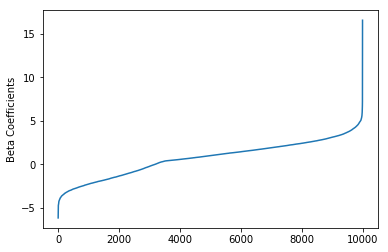

In [52]:
beta = np.sort(logistic_model.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

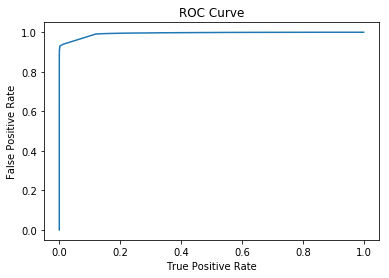

Training set areaUnderROC: 0.9938039909855111


In [53]:
trainingSummary = logistic_model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

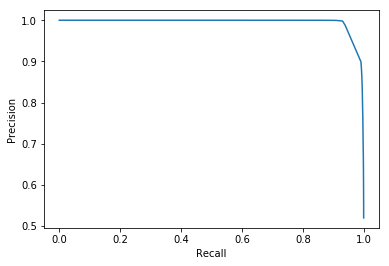

In [54]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [61]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [62]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)

IllegalArgumentException: 'Field "label" does not exist.\nAvailable fields: text, words, filtered, features, rawPrediction, probability, prediction'